<b style="color:#000000;font-size:20px;">MT2021037 - Transfusion classification problem with logistic regression</b>
<p style="font-size:17px">Starting with some imports!<p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

In [2]:
np.random.seed(4)

<p style="font-size:17px">Preprocess data, just as we did in linear regression<p>

In [3]:
def delete_outliers(all_data):
    for f in all_data.columns.values:
        #removing data that is 3 times standard deviation away from mean of that column
        index = all_data[np.abs(all_data[f]-all_data[f].mean()) > (3*all_data[f].std())].index
        all_data.drop(index, inplace=True)
        
def preprocess(all_data):
    all_data.drop_duplicates(inplace = True, keep = 'first')
    for f in all_data.columns.values:
        if(all_data[f].dtype == 'O'):
            col_data = all_data[f].to_numpy()
            for i in range(col_data.shape[0]):
                try:
                    col_data[i] = float(col_data[i])
                except ValueError:
                    col_data[i] = np.nan
            all_data[f] = col_data
            del col_data;
            gc.collect();
        #filling null values with mean of the data
        all_data[f].fillna(all_data[f].mean(), inplace = True)
        all_data[f] = all_data[f].astype(np.float32)
        plt.xlabel(f)
        plt.boxplot(all_data[f])
        plt.show()
    delete_outliers(all_data)

<p style="font-size:17px">Load the data and change column names to make them easy to work with!<p>

In [4]:
all_data = pd.read_csv("transfusion.csv")
all_data.columns = ["months","freq","blood","time","target"]

In [5]:
all_data.describe()

,months,freq,blood,time,target
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   months  748 non-null    int64
 1   freq    748 non-null    int64
 2   blood   748 non-null    int64
 3   time    748 non-null    int64
 4   target  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


<p style="font-size:17px">Outliear analysis and removal<p>

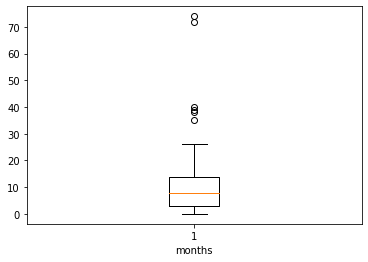

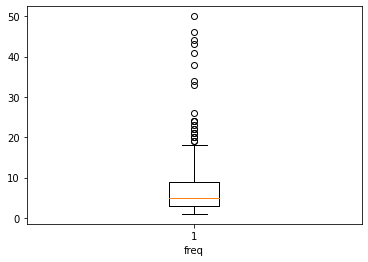

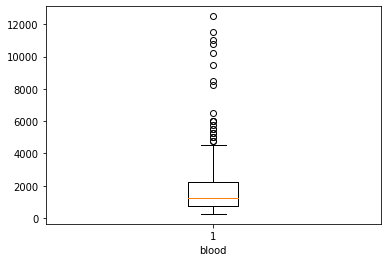

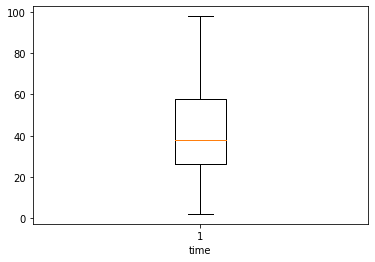

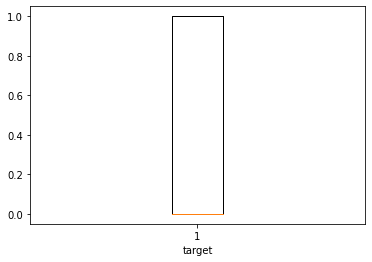

In [7]:
preprocess(all_data)

<p style="font-size:17px">Correlation analysis<p>

In [8]:
all_data.target.value_counts() 

0.0    371
1.0    139
Name: target, dtype: int64

<p style="font-size:17px">Preprocess and make the train data.<p>

<p style="font-size:17px">Make the structure of MODEL.<p>

In [9]:
class LogisticRegression():
    #LOG LOSS / CROSS ENTROPY LOSS FUNCTION
    def cost_function(self,y_true, y_pred):
        ans = (-1) * (1 - y_true)*np.log(1-y_pred)
        ans += (-1) * (y_true) * np.log(y_pred)
        return np.sum(ans)/(y_true.shape[0])    
    
    #GRADIENT CALCULATION
    def grads(self,y_true, y_pred, X):
        cos = (y_pred - y_true)
        cos = np.dot(np.transpose(cos), X)
        return np.transpose(cos/y_true.shape[0]);

    #HESSIAN MATRIX CALCULATION FOR NEWTON's METHOD
    def hess(self,y_pred, X):
        m = X.shape[0]
        n = X.shape[1]
        ans = np.zeros((n,n))
        for i in range(m):
            sample = X[i]
            ans += float(y_pred[i] * (1-y_pred[i])) * np.dot(np.reshape(sample, (-1, 1)), np.reshape(sample, (1, -1)))
        ans /= m;
        return ans;

    #DELTA CALCULATION FOR NEWTON's METHODS
    def hess_grad(self,y_true,y_pred,X):
        return np.dot(np.linalg.pinv(self.hess(y_pred, X)), self.grads(y_true, y_pred, X));

    #SIGMOID CALCULATION
    def sigmoid(self,x):
        return 1/(1 + np.exp((-1) * x))
    
    #HYPOTHESIS CALCULATION
    def hypo(self,X, theta):
        return self.sigmoid(np.dot(X, theta))
    
    #PREDICTIONS!
    def predict(self,X, theta):
        preds = self.hypo(X, theta)
        preds[preds>=0.4] = 1;
        return preds.astype(int)
    
    def accuracy(self,y_true, preds):
        return (1-np.sum(np.abs(y_true - preds))/y_true.shape[0])*100
    
    #TRAIN FUNCTION (hess = True for newton's method)
    def fit(self,X_train, y_train, learning_rate = 0.1, epochs = 1000, hess = False):
        costs = []
        theta = np.random.randn(X_train.shape[1],1)
        for i in range(epochs):
            y_preds = self.hypo(X_train, theta)
            cost = self.cost_function(y_train, y_preds)
            costs.append(cost)
            if(hess):
                theta -= self.hess_grad(y_train, y_preds, X_train)
            else:
                theta -= (learning_rate)*self.grads(y_train, y_preds, X_train)
        print("f1 score : " + str(self.f1_score(self.predict(X_train, theta), y_train)))
        self.plot(costs)
        return (theta, costs)
    
    #PLOT COSTS
    
    def f1_score(self, y_pred, y_act):
        tp = sum((y_act == 1) & (y_pred == 1))
        tn = sum((y_act == 0) & (y_pred == 0))
        fn = sum((y_act == 1) & (y_pred == 0))
        fp = sum((y_act == 0) & (y_pred == 1))
        return ((tp + tn) * 100)/ float( tp + tn + fn + fp)
    
    def plot(self,costs):
        x = list(range(len(costs)))
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(x, costs, color='green', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=4)
        plt.show()

In [10]:
features = [f for f in all_data.columns.values if not f == "target"]
X_train = all_data[features]
#Data Normalisation
X_train = (X_train-X_train.mean())/X_train.std()
X_train["bias"] = 1;
X_train = X_train.to_numpy()
y_train = all_data["target"].to_numpy()
y_train = np.reshape(y_train, (-1,1))

TRAINING ON ALL FEATURES
f1 score : [74.90196078]


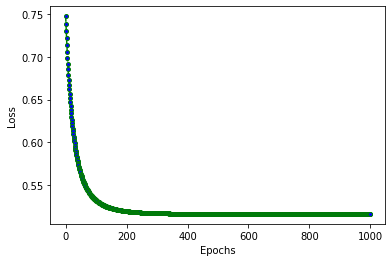



UNIVARIATE STARTS NOW!
TRAINING ON months
f1 score : [68.82352941]


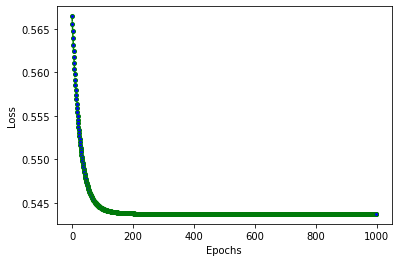

TRAINING ON freq
f1 score : [72.94117647]


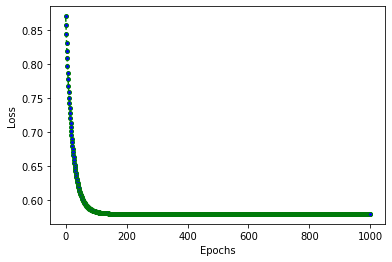

TRAINING ON blood
f1 score : [72.94117647]


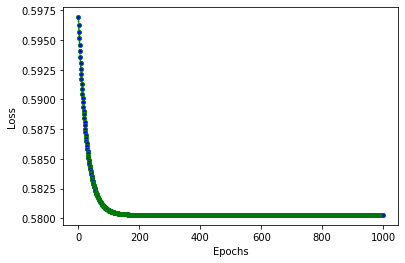

TRAINING ON time
f1 score : [72.54901961]


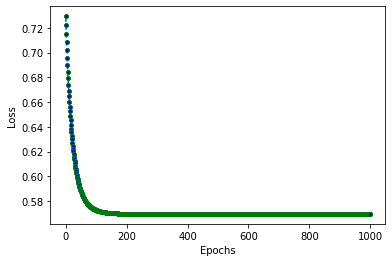

In [11]:
lr = LogisticRegression()
print("TRAINING ON ALL FEATURES")
lr.fit(X_train, y_train)
print();
print();
print("UNIVARIATE STARTS NOW!")
columns = [col for col in features if not col == "bias"]
all_data["bias"] = 1;
for col in columns:
    print("TRAINING ON " + str(col))
    x_train = all_data[["bias",col]].copy();
    x_train[col] = (x_train[col] - x_train[col].mean())/x_train[col].std()
    x_train = x_train.values
    lr.fit(x_train, y_train);
    plt.show()

<p style="font-size:17px">Newton's method<p>

f1 score : [74.90196078]


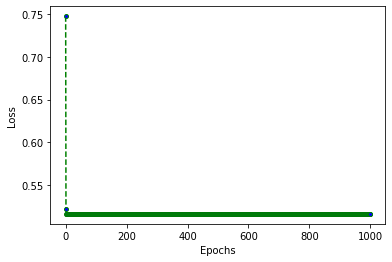

In [12]:
np.random.seed(4)
theta, costs = lr.fit(X_train, y_train, hess = True)

<p style="font-size:17px">N BAYES CLASSIFIER!<p>

In [13]:
class MyBayesClassifier():
    def calc_stats(self,X_train, y_train):
        self.mean = X_train.groupby(y_train).apply(np.mean).to_numpy();
        self.var = X_train.groupby(y_train).apply(np.var).to_numpy();
        
    def calc_prior(self, X_train, y_train):
        size = X_train.shape[0]
        self.prior =  X_train.groupby(y_train).apply(lambda x : len(x)/size).to_numpy()
        
    def gaussian_prob(self, sample):
        pros = []
        for i in range(self.count):
            mean = self.mean[i]
            var = self.var[i]
            numerator = np.exp(((sample-mean)**2)/(-2*var))
            denominator = np.sqrt(np.pi * 2 * var)
            prob = numerator/denominator
            sample_pros = np.sum(np.log(prob)) + np.log(self.prior[i])
            pros.append(sample_pros)
        return self.classes[np.argmax(pros)]
    
    def predict(self, X):
        return [self.gaussian_prob(sample) for sample in X]
    
    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        self.count = len(self.classes)
        self.calc_stats(X_train, y_train)
        self.calc_prior(X_train, y_train)
    
    def f1_score(self, y_pred, y_act):
        y_pred = np.reshape(y_pred, (-1,))
        y_act = np.reshape(y_act, (-1,))
        tp = sum((y_act == 1) & (y_pred == 1))
        tn = sum((y_act == 0) & (y_pred == 0))
        fn = sum((y_act == 1) & (y_pred == 0))
        fp = sum((y_act == 0) & (y_pred == 1))
        return ((tp + tn) * 100)/ float( tp + tn + fn + fp)

In [14]:
features = [f for f in all_data.columns if f != "target"]
X_train = all_data[features]
X_train = (X_train-X_train.mean())/X_train.std()
y_train = all_data["target"].to_numpy()

classifier = MyBayesClassifier()
classifier.fit(X_train, y_train)
preds_3 = classifier.predict(X_train.to_numpy())
print("F1 score is " + str(classifier.f1_score(classifier.predict(X_train.to_numpy()), y_train))); 
nbc = MyBayesClassifier()
print("TRAINING ON ALL FEATURES")
nbc.fit(X_train, y_train)
print();
print();
print("UNIVARIATE STARTS NOW!")
columns = [col for col in features if not col == "bias"]
all_data["bias"] = 1;
for col in columns:
    print("TRAINING ON " + str(col))
    x_train = all_data[["bias",col]].copy();
    x_train[col] = (x_train[col] - x_train[col].mean())/x_train[col].std()
    x_train = x_train
    nbc.fit(x_train, y_train)
    print("F1 score is " + str(nbc.f1_score(nbc.predict(x_train.to_numpy()), y_train)));
    plt.show()

F1 score is 72.74509803921569
TRAINING ON ALL FEATURES


UNIVARIATE STARTS NOW!
TRAINING ON months
F1 score is 72.74509803921569
TRAINING ON freq
F1 score is 72.74509803921569
TRAINING ON blood
F1 score is 72.74509803921569
TRAINING ON time
F1 score is 72.74509803921569


In [15]:
accuracy = 1 - np.sum(np.abs(preds_3 - y_train)) / y_train.shape[0]
print(accuracy*100)

72.74509803921569


<p style="font-size:27px">What features can be best modelled by MVG?<p>

In [16]:
all_data.drop("bias", axis = "columns", inplace = True)

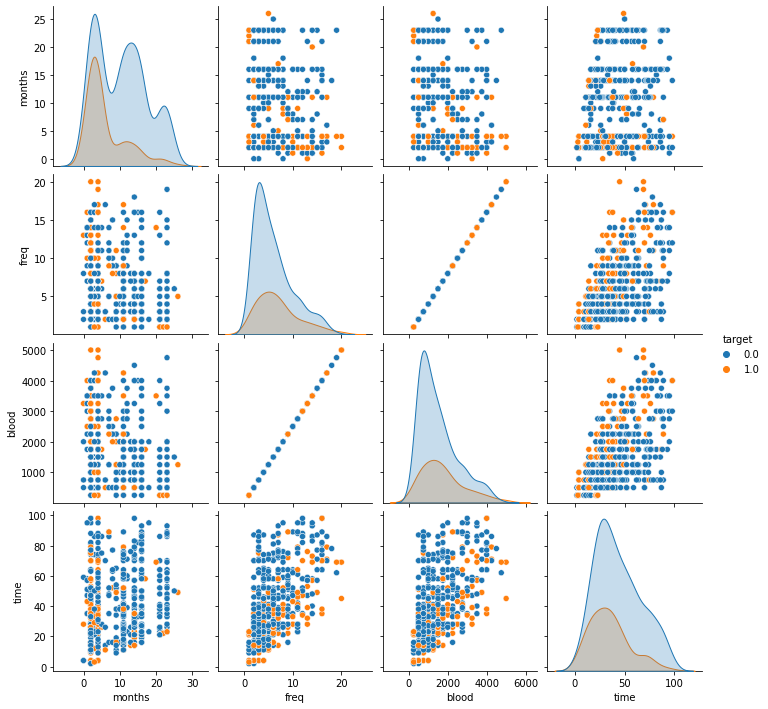

In [17]:
sns.pairplot(all_data, hue="target")

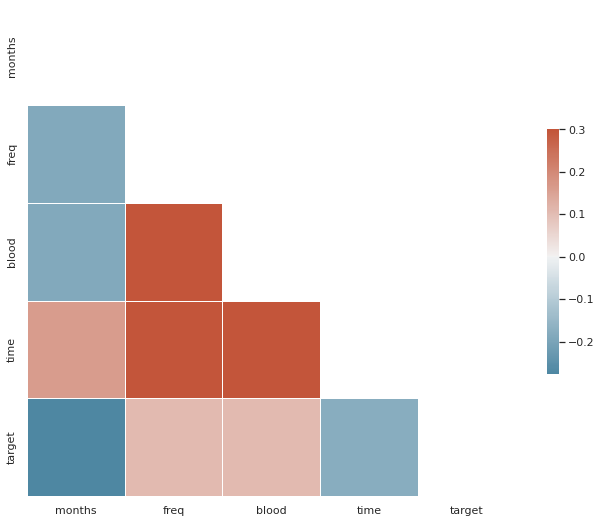

In [18]:
sns.set_theme(style="white")
corr = all_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

<p style="font-size:17px">After doing some correlation analysis and going through the above pairwise distributions, we can say that blood, freq, time can be best modelled by MVG to capture the large variance in target.<p>

<p style="font-size:17px">Let's see!<p>

In [19]:
nbc = MyBayesClassifier()
X_train = all_data[["months", "freq", "time"]].copy()
X_train = (X_train - X_train.mean())/X_train.std()
nbc.fit(X_train, y_train)

In [20]:
print("F1 score is " + str(nbc.f1_score(nbc.predict(X_train.to_numpy()), y_train)));

F1 score is 74.90196078431373


<p style="font-size:29px">We did it!,we got more f1 score using just months, freq, time compared to all variables<p>